In [1]:
# Standard library imports
import math
import logging
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn, tensor, optim
from torchvision import datasets
from torch.utils.data import DataLoader

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data handling and datasets
from datasets import load_dataset, load_dataset_builder
import torchvision.transforms.functional as TF
from fastprogress import progress_bar, master_bar

# Fastcore utilities
import fastcore.all as fc
from fastcore.test import test_close

# Custom module imports
from miniai.conv import *
from miniai.datasets import *

In [2]:
m, nh = 28 * 28, 50

def get_model():
    return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

model = get_model()

In [3]:
# Custom transform to flatten the input tensor
def flatten_transform(image):
    return torch.flatten(TF.to_tensor(image))

# Load the FashionMNIST dataset with the custom transform
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=flatten_transform  # Applying transform here
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=flatten_transform  # Applying transform here
)

# Create the train and test dataloaders
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Define a DataLoaders class to wrap the train and test dataloaders
class DataLoaders:
    def __init__(self, train, valid):
        self.train = train
        self.valid = valid

# Create the `dls` object with train and valid attributes
dls = DataLoaders(train_dataloader, test_dataloader)

In [4]:
import inspect

def store_attr(except_attrs=None):
    """
    Store arguments passed to a method as attributes on the instance (self).
    Optionally skip certain attributes using `except_attrs`.
    """
    # Get the current frame to access locals
    frame = inspect.currentframe().f_back
    args, _, _, values = inspect.getargvalues(frame)
    
    except_attrs = except_attrs or []
    
    # For each argument, store it as an instance attribute
    for arg in args:
        if arg != 'self' and arg not in except_attrs:
            setattr(values['self'], arg, values[arg])

In [5]:
def run_cbs(cbs, method_nm, learner=None):
    for cb in cbs:
        method = getattr(cb, method_nm, None)
        if method is not None:
            method(learner)

In [6]:
def to_cpu(x):
    if isinstance(x, Mapping): 
        return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): 
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple): 
        return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [7]:
class with_cbs:
    def __init__(self, nm):
        self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']:
                pass
            finally:
                o.callback(f'cleanup_{self.nm}')
        return _f

In [8]:
class Callback():
    order = 0

In [9]:
class TrainCB(Callback):
    def __init__(self, n_inp=1):
        self.n_inp = n_inp
    def predict(self, learn):
        print("predict")
    def get_loss(self, learn):
        print("get_loss")
    def backward(self, learn):
        print("backward")
    def step(self, learn):
        print("step")
    def zero_grad(self, learn):
        print("zero_grad")

In [10]:
class DeviceCB(Callback):
    def __init__(self, device=def_device):
        store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'):
            learn.model.to(self.device)
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)

In [11]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d):
        print(d)

    def before_fit(self, learn):
        learn.metrics = self

    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [12]:
class CancelFitException(Exception):
    pass
class CancelEpochException(Exception):
    pass
class CancelBatchException(Exception):
    pass

In [13]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl):
            self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train:
                self.one_epoch(True)
            if valid:
                torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs:
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None:
                lr = self.lr
            if self.opt_func:
                self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self):
        return self.model.training

In [14]:
class TrainLearner(Learner):
    def predict(self):
        self.preds = self.model(self.batch[0])
    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self):
        self.loss.backward()
    def step(self):
        self.opt.step()
    def zero_grad(self):
        self.opt.zero_grad()

In [15]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                p.grad *= self.mom

In [16]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3):
        store_attr()
    
    def before_fit(self, learn):
        self.lrs, self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training:
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min:
            self.min = loss
        if loss > self.min*3:
            raise CancelFitException()
        
        for g in learn.opt.param_groups:    
            g['lr'] *= self.lr_mult

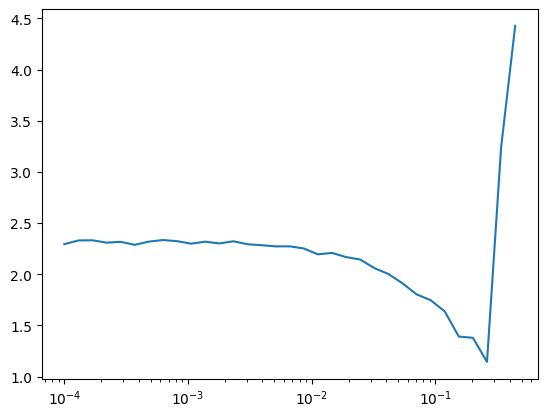

In [17]:
lrfind = LRFinderCB()
cbs = [lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')